# Implementing tile overlap

In [195]:
import glob
import os
import enum
import re
import dask
import dask.array as da
import skimage
from skimage.io import imshow
import numpy as np
from tqdm.auto import tqdm
import napari
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

In [2]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    MASK_2 = 97
    MASK_1 = 98
    MASK = 99

def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusHeavy filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSHEAVY_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<mosaic_pos>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    path, filename = os.path.split(filename)
    params = re.match(OCTOPUSHEAVY_FILEPATTERN, filename)

    filename_metadata = {
        "filename": filename,
        "channel": params.group("channel"),# Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "mosaic_pos": params.group("mosaic_pos"), 
        "plane": params.group("plane"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return filename_metadata

In [197]:
def read_harmony_metadata(metadata_path: os.PathLike):
    """
    Read the metadata from the Harmony software for the Opera Phenix microscope.
    Takes an input of the path to the metadata .xml file.
    Returns the metadata in a pandas dataframe format.
    """
    
    ### read xml metadata file
    xml_data = open(metadata_fn, 'r').read()
    root = ET.XML(xml_data) 
    ### extract the metadata from the xml file
    images_metadata = [child for child in root if "Images" in child.tag][0]
    ### create an empty list for storing individual image metadata
    all_images_dicts = list()
    ### iterate over every image entry extracting the metadata
    for image_metadata in tqdm(images_metadata, total = len(images_metadata)):
        ### create empty dict to store single image metadata
        single_image_dict = dict()
        ### iterate over every metadata item in that image metadata
        for item in image_metadata:
            ### get column names from metadata
            col = item.tag.replace('{http://www.perkinelmer.com/PEHH/HarmonyV5}','')
            ### get metadata
            entry = item.text
            ### make dictionary out of metadata
            single_image_dict[col] = entry
        ### append that image metadata to list of all images    
        all_images_dicts.append(single_image_dict)
    ### create a dataframe out of all metadata
    df = pd.DataFrame(all_images_dicts)
    
    return df

# Define FOV you want to work with

In [217]:
row = 4
col = 4

#### Find images

In [219]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
# image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/r03c03f01p01/'
# fns = glob.glob(os.path.join(image_dir, '*.tiff'))
fns = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}*.tiff'))
print(len(fns), 'image files found')

4050 image files found


### Loading metadata

In [200]:
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
df = read_harmony_metadata(metadata_fn)

  0%|          | 0/113400 [00:00<?, ?it/s]

#### Lazily load as dask array 

In [201]:
%%time
sample = skimage.io.imread(fns[0])
lazy_arrays = [dask.delayed(skimage.io.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)#'uint8')#
               for x in lazy_arrays]

CPU times: user 553 ms, sys: 11.8 ms, total: 565 ms
Wall time: 571 ms


#### Organise said dask array based on filename metadata

In [202]:
### get dimensions
dimensions = dict()
for fn in fns:
    for prop in ['channel', 'time', 'row', 'column', 'mosaic_pos', 'plane']:
        dimensions.setdefault(prop, set())
        dimensions[prop].add(int(parse_filename(fn)[prop]))

## Important nomenclature note:

Row and column in the metadata is used to signify the row and column of the FOV position in the imaging dish. 
Row and column can also refer to the position of the image tile within the composite image mosaic. 

In [203]:
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))

### Create an empty placeholder for all images

In [204]:
image_nd_array = np.empty((
              len(dimensions['time']),
              len(dimensions['channel']),
              len(dimensions['plane']),
              int(np.sqrt(len(dimensions['mosaic_pos']))),
              int(np.sqrt(len(dimensions['mosaic_pos'])))
              ), 
              dtype = object)
print("Image shape:", image_nd_array.shape)

Image shape: (75, 2, 3, 3, 3)


## Fill placeholder with chunks

In [205]:
for fn, frame in tqdm(zip(fns, lazy_arrays), total = len(lazy_arrays)): 
    filename_metadata = parse_filename(fn)
    mosaic_pos = int(filename_metadata['mosaic_pos'])
    mosaic_row_col = np.where(fov_scan_pattern == mosaic_pos)
    mosaic_row = mosaic_row_col[0][0]
    mosaic_column = mosaic_row_col[1][0]
    time = int(filename_metadata['time'])
    plane = int(filename_metadata['plane'])
    fov_row = int(filename_metadata['row'])
    fov_column = int(filename_metadata['column'])
    channel = int(filename_metadata['channel'])
    image_nd_array[time-1, channel-1, plane-1, mosaic_row-1, mosaic_column-1,] = frame

  0%|          | 0/4050 [00:00<?, ?it/s]

### Now I have a numpy array of dask chunks, compile into a block

In [206]:
image = da.block(image_nd_array.tolist())
image

dask.array<concatenate, shape=(75, 2, 3, 6480, 6480), dtype=uint16, chunksize=(1, 1, 1, 2160, 2160), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


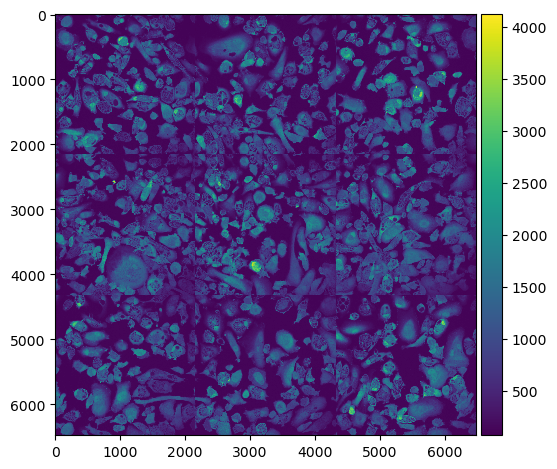

In [271]:
imshow(image[0,0,0])

# Trying sophisticated approach

Trying to implement a fucntion to correctly tile using metadata that I could then implement in `map_blocks()`

### Inspect metadata for this position

In [241]:
df.keys()

Index(['id', 'State', 'URL', 'Row', 'Col', 'FieldID', 'PlaneID', 'TimepointID',
       'ChannelID', 'FlimID', 'ChannelName', 'ImageType', 'AcquisitionType',
       'IlluminationType', 'ChannelType', 'ImageResolutionX',
       'ImageResolutionY', 'ImageSizeX', 'ImageSizeY', 'BinningX', 'BinningY',
       'MaxIntensity', 'CameraType', 'PositionX', 'PositionY', 'PositionZ',
       'AbsPositionZ', 'MeasurementTimeOffset', 'AbsTime',
       'MainExcitationWavelength', 'MainEmissionWavelength',
       'ObjectiveMagnification', 'ObjectiveNA', 'ExposureTime',
       'OrientationMatrix'],
      dtype='object')

In [242]:
coords = df.loc[(df['Row'] == f'{row}') & (df['Col'] == f'{col}'), ("URL", "PositionX", "PositionY", "PositionZ", "ImageResolutionX", "ImageResolutionY")]
coords

URL    PositionX    PositionY PositionZ  \
486      r04c04f01p01-ch1sk1fk1fl1.tiff            0  0.000581233         0   
487      r04c04f01p01-ch2sk1fk1fl1.tiff            0  0.000581233         0   
488      r04c04f01p02-ch1sk1fk1fl1.tiff            0  0.000581233     2E-06   
489      r04c04f01p02-ch2sk1fk1fl1.tiff            0  0.000581233     2E-06   
490      r04c04f01p03-ch1sk1fk1fl1.tiff            0  0.000581233     4E-06   
...                                 ...          ...          ...       ...   
112423  r04c04f09p01-ch2sk75fk1fl1.tiff  0.000290616  0.000581233         0   
112424  r04c04f09p02-ch1sk75fk1fl1.tiff  0.000290616  0.000581233     2E-06   
112425  r04c04f09p02-ch2sk75fk1fl1.tiff  0.000290616  0.000581233     2E-06   
112426  r04c04f09p03-ch1sk75fk1fl1.tiff  0.000290616  0.000581233     4E-06   
112427  r04c04f09p03-ch2sk75fk1fl1.tiff  0.000290616  0.000581233     4E-06   

              ImageResolutionX        ImageResolutionY  
486     1.4949402023919043E-07  1.4949402023919043E-07  
487     1.4949402023919043E-07  1.4949402023919043E-07  
488     1.4949402023919043E-07  1.4949402023919043E-07  
489     1.4949402023919043E-07  1.4949402023919043E-07  
490     1.4949402023919043E-07  1.4949402023919043E-07  
...                        ...                     ...  
112423  1.4949402023919043E-07  1.4949402023919043E-07  
112424  1.4949402023919043E-07  1.4949402023919043E-07  
112425  1.4949402023919043E-07  1.4949402023919043E-07  
112426  1.4949402023919043E-07  1.4949402023919043E-07  
112427  1.4949402023919043E-07  1.4949402023919043E-07  

[4050 rows x 6 columns]

In [255]:
coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)

In [265]:
norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))
norm_coords

[(0.0, 3888.001667692308),
 (0.0, 3888.001667692308),
 (0.0, 3888.001667692308),
 (0.0, 3888.001667692308),
 (0.0, 3888.001667692308),
 (0.0, 3888.001667692308),
 (-1943.9974892307694, 7775.996646153846),
 (-1943.9974892307694, 7775.996646153846),
 (-1943.9974892307694, 7775.996646153846),
 (-1943.9974892307694, 7775.996646153846),
 (-1943.9974892307694, 7775.996646153846),
 (-1943.9974892307694, 7775.996646153846),
 (0.0, 7775.996646153846),
 (0.0, 7775.996646153846),
 (0.0, 7775.996646153846),
 (0.0, 7775.996646153846),
 (0.0, 7775.996646153846),
 (0.0, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 7775.996646153846),
 (1943.9974892307694, 5831.999156923077),
 (1943.9974892307694, 5831.999156923077),
 (1943.9974892307694, 5831.999156923077),
 (1943.9974892307694, 5831.999156923077)

In [274]:
tile_shape = lazy_arrays[0].shape
tile_shape

(2160, 2160)

In [282]:


transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
tiles = [get_transformed_array_corners(tile_shape, transform) for transform in transforms]



     


In [284]:
tiles_shapely = [numpy_shape_to_shapely(s) for s in tiles]

In [ ]:
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shapely)))

In [286]:
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
stitched_shape

(6048, 6048)

In [289]:
shift_to_origin = AffineTransform(translation=-all_min)
shift_to_origin.params

array([[ 1.00000000e+00, -0.00000000e+00,  1.94399749e+03],
       [ 0.00000000e+00,  1.00000000e+00, -3.88800167e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [290]:
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [get_transformed_array_corners(tile_shape, t) for t in transforms_with_shift]

In [ ]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shifted_shapely)))

In [294]:
chunk_size = (6048/3,6048/3)
chunk_size

(2016.0, 2016.0)

In [295]:
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
chunks

((2016, 2016, 2016), (2016, 2016, 2016))

In [297]:
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)
computed_shape, stitched_shape

(array([6048, 6048]), (6048, 6048))

In [301]:
chunk_boundaries = list(get_chunk_coordinates(stitched_shape, chunk_size))
chunk_boundaries

[((0, 2016), (0, 2016)),
 ((0, 2016), (2016, 4032)),
 ((0, 2016), (4032, 6048)),
 ((2016, 4032), (0, 2016)),
 ((2016, 4032), (2016, 4032)),
 ((2016, 4032), (4032, 6048)),
 ((4032, 6048), (0, 2016)),
 ((4032, 6048), (2016, 4032)),
 ((4032, 6048), (4032, 6048))]

In [302]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

In [ ]:
GeometryCollection([origin, 
                    GeometryCollection(tiles_shifted_shapely), 
                    GeometryCollection(chunks_shapely),])

In [305]:
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely, 
                                                 fns, 
                                                 transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}

/tmp/ipykernel_700135/2941809627.py:4: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  tile_shifted_shapely.fuse_info = {'file':file, 'transform':transform}


In [307]:
for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}

/tmp/ipykernel_700135/1780256429.py:2: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}


In [308]:
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)
chunk_tiles

{(0,
  0): [('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c04f06p02-ch2sk32fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c04f07p01-ch2sk34fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c04f02p03-ch2sk27fk1fl1.tiff',
   array([[1.00000000e+00, 0.00000000e+00, 1.94399749e+03],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c04f01p03-ch1sk30f

dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [317]:
_load_image = partial(load_image, transforms=[])#input_transforms)

In [319]:
_fuse_func=partial(fuse_func, 
                   imload_fn=_load_image,
                   dtype=np.uint8)

target_array = da.map_blocks(func=_fuse_func,
                             chunks=chunks, 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)
target_array

dask.array<fuse_func, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [321]:
target_array.compute()

Processing chunk at (0, 0)
Processing chunk at (0, 2016)Processing chunk at (0, 4032)

Processing chunk at (2016, 0)
Processing chunk at (2016, 2016)
Processing chunk at (2016, 4032)
Processing chunk at (4032, 0)
Processing chunk at (4032, 2016)
Processing chunk at (4032, 4032)



KeyboardInterrupt



In [352]:
len(chunk_tiles[(0,0)])

1800

In [353]:
len(chunk_tiles[(0,0)])*9

16200

In [ ]:
da.map_blocks`

In [279]:
import sys
sys.path.append('../')
from DaskFusion import utils

In [316]:
import time
from functools import partial
from pathlib import Path
from zipfile import ZipFile
import dask.array as da
from dask.array.core import normalize_chunks
import numpy as np
from shapely.geometry import GeometryCollection, Point
from skimage.transform import AffineTransform
from DaskFusion.fuse.fuse import fuse_func
# from utils.download_sample import download_from_dropbox
# from utils.metadata import extract_coordinates, normalize_coords_to_pixel
from DaskFusion.utils.imutils import crop_black_border, load_image, transpose
from DaskFusion.utils.shapely_and_napari_utils import get_transformed_array_corners, numpy_shape_to_shapely
from DaskFusion.utils.chunks import get_chunk_coordinates, get_rect_from_chunk_boundary, find_chunk_tile_intersections

# Merge both approaches

In [ ]:
image = da.block(image_nd_array.tolist())
image

## Fill placeholder with chunks

In [205]:
for fn, frame in tqdm(zip(fns, lazy_arrays), total = len(lazy_arrays)): 
    filename_metadata = parse_filename(fn)
    mosaic_pos = int(filename_metadata['mosaic_pos'])
    mosaic_row_col = np.where(fov_scan_pattern == mosaic_pos)
    mosaic_row = mosaic_row_col[0][0]
    mosaic_column = mosaic_row_col[1][0]
    time = int(filename_metadata['time'])
    plane = int(filename_metadata['plane'])
    fov_row = int(filename_metadata['row'])
    fov_column = int(filename_metadata['column'])
    channel = int(filename_metadata['channel'])
    image_nd_array[time-1, channel-1, plane-1, mosaic_row-1, mosaic_column-1,] = frame

  0%|          | 0/4050 [00:00<?, ?it/s]

In [323]:
help(da.map_blocks)

Help on function map_blocks in module dask.array.core:

map_blocks(func, *args, name=None, token=None, dtype=None, chunks=None, drop_axis=[], new_axis=None, meta=None, **kwargs)
    Map a function across all blocks of a dask array.
    
    Note that ``map_blocks`` will attempt to automatically determine the output
    array type by calling ``func`` on 0-d versions of the inputs. Please refer to
    the ``meta`` keyword argument below if you expect that the function will not
    succeed when operating on 0-d arrays.
    
    Parameters
    ----------
    func : callable
        Function to apply to every block in the array.
    args : dask arrays or other objects
    dtype : np.dtype, optional
        The ``dtype`` of the output array. It is recommended to provide this.
        If not provided, will be inferred by applying the function to a small
        set of fake data.
    chunks : tuple, optional
        Chunk shape of resulting blocks if the function does not preserve
        shap

### Now I have a numpy array of dask chunks, compile into a block

In [206]:
image = da.block(image_nd_array.tolist())
image

dask.array<concatenate, shape=(75, 2, 3, 6480, 6480), dtype=uint16, chunksize=(1, 1, 1, 2160, 2160), chunktype=numpy.ndarray>

In [324]:
tiles

[array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[   0.        , 3888.00166769],
        [2160.        , 3888.00166769],
        [2160.        , 6048.00166769],
        [   0.        , 6048.00166769]]),
 array([[-1943.99748923,  77

In [325]:
image

dask.array<concatenate, shape=(75, 2, 3, 6480, 6480), dtype=uint16, chunksize=(1, 1, 1, 2160, 2160), chunktype=numpy.ndarray>

In [334]:
tile_map = da.map_blocks(procedure, image)

proceduring (0, 0, 0, 0, 0)
proceduring (1, 1, 1, 1, 1)


proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring  (1, 1, 1, 2160, 2160)
(1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
 (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring (1, 1, 1, 2160, 2160)
 (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring  (1, 1, 1, 2160, 2160)
(1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring  (1, 1, 1, 2160, 2160)
(1, 1, 1, 2160, 2160)proceduring
 (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring proceduring(1, 1, 1, 2160, 2160)
 (1, 1, 1, 2160, 2160)
proceduringproceduring (1, 1, 1, 2160, 2160)
 (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduringproceduring (1, 1, 1, 2160, 2160)
 (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1, 1, 1, 2160, 2160)
proceduring (1

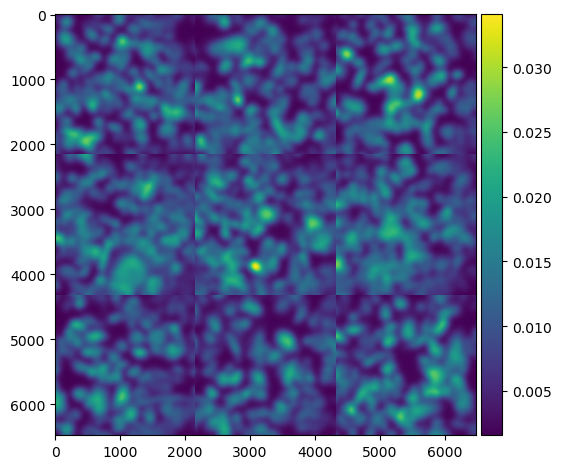

In [335]:
imshow(tile_map[0,0,0])

In [326]:
from skimage.filters import gaussian

In [336]:
def procedure(image):
    print("proceduring", image.shape)
    return gaussian(image, sigma=1)
    return image

In [ ]:
overlap_image = da.map_overlap(procedure, image, depth=1)

In [338]:
overlap_image

dask.array<_trim, shape=(75, 2, 3, 6480, 6480), dtype=float64, chunksize=(1, 1, 1, 2160, 2160), chunktype=numpy.ndarray>

# Can i implement the fuse function in the da.map_blocks

In [342]:
help(da.map_blocks)

Help on function map_blocks in module dask.array.core:

map_blocks(func, *args, name=None, token=None, dtype=None, chunks=None, drop_axis=[], new_axis=None, meta=None, **kwargs)
    Map a function across all blocks of a dask array.
    
    Note that ``map_blocks`` will attempt to automatically determine the output
    array type by calling ``func`` on 0-d versions of the inputs. Please refer to
    the ``meta`` keyword argument below if you expect that the function will not
    succeed when operating on 0-d arrays.
    
    Parameters
    ----------
    func : callable
        Function to apply to every block in the array.
    args : dask arrays or other objects
    dtype : np.dtype, optional
        The ``dtype`` of the output array. It is recommended to provide this.
        If not provided, will be inferred by applying the function to a small
        set of fake data.
    chunks : tuple, optional
        Chunk shape of resulting blocks if the function does not preserve
        shap

In [345]:
help(da.map_overlap)

Help on function map_overlap in module dask.array.overlap:

map_overlap(func, *args, depth=None, boundary=None, trim=True, align_arrays=True, **kwargs)
    Map a function over blocks of arrays with some overlap
    
    We share neighboring zones between blocks of the array, map a
    function, and then trim away the neighboring strips. If depth is
    larger than any chunk along a particular axis, then the array is
    rechunked.
    
    Note that this function will attempt to automatically determine the output
    array type before computing it, please refer to the ``meta`` keyword argument
    in ``map_blocks`` if you expect that the function will not succeed when
    operating on 0-d arrays.
    
    Parameters
    ----------
    func: function
        The function to apply to each extended block.
        If multiple arrays are provided, then the function should expect to
        receive chunks of each array in the same order.
    args : dask arrays
    depth: int, tuple, dict or 

In [340]:
da.map_blocks(func=_fuse_func,
                    image)
#                              chunks=chunks, 
#                              input_tile_info=chunk_tiles,
#                              dtype=np.uint8)

SyntaxError: positional argument follows keyword argument (3883225501.py, line 2)

# Conclusion:

Need to try and tile maybe using map_overlap so that later functions can be applied cleverly...

Although dask fusion needs to be implemented to properly overlap so maybe just use that then use dask map overlap... im very confused!

# https://blog.dask.org/2019/06/20/load-image-data try revisiting this tomorrow

# Key points:

1. `da.map_overlap()` is an approach that applies a function over your dask array with an overlap taken into consideration
2. `da.map_blocks()` is an approach to map a function over an dask array with certain size blocks...

Therefore seems to me like I need to assemble my dask array with overlap prior to using any of these functions.

# Reconfiguring Hilderstein approach for mosaic from dask fusion

In [354]:
# load multichannel image in one line, with additional options
viewer = napari.view_image(
        image,
        channel_axis=1,
        name=["macrophage", "Mtb"],
        colormap=["green", "magenta"],
#         contrast_limits=[[1000, 20000], [1000, 50000]],
#         )
)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


### (for later) We can Map a function on all individual tiles using `da.map_blocks`. This does not process the whole image yet. 

In [ ]:
image = da.map_blocks(procedure, tiles)

In [ ]:
image = da.map_overlap(procedure, tiles, depth = overlap_width)

In [ ]:
image = image.compute() ###!!! dont actually do this yet lol

## Define mosaic composition

In [33]:
### array that shows the location of each fov in the scan pattern
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))
fov_scan_pattern

array([[2, 3, 4],
       [7, 6, 5],
       [8, 1, 9]])

In [10]:
fns = glob.glob(os.path.join(image_dir, '*.tiff'))

In [30]:
import os, glob, re, enum

In [3]:
from skimage.io import imread, imshow

In [11]:
len(fns)

113400

In [12]:
fns[0]

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f08p02-ch1sk36fk1fl1.tiff'

In [13]:
fn = fns[0]

In [14]:
int(re.search('r(\d+)', fn).group(1))

3

### Dask array

In [47]:
import dask
import dask.array as da
import imageio
import numpy as np

In [34]:
sample = imageio.imread(fns[0])
sample.shape

(2160, 2160)

In [19]:
lazy_arrays = [dask.delayed(imageio.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]

In [21]:
len(lazy_arrays)

113400

In [35]:
lazy_arrays[0]

dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [36]:
da.stack(lazy_arrays[:10], axis=0)

dask.array<stack, shape=(10, 2160, 2160), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

## da.block example

In [30]:
import enum
@enum.unique
class metadata(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    filename = 0
    channel = 1
    time = 2
    row = 3
    column = 4
    fov = 5
    plane = 6
    fk = 7
    fl = 8

In [31]:
fn_metadata = dict()
for fn in fns:
    for i, row_col in enumerate(extract_fn_metadata(fn)):
        fn_metadata.setdefault(metadata(i).name, set())
        fn_metadata[metadata(i).name].add(row_col)

NameError: name 'extract_fn_metadata' is not defined

In [44]:
fn_metadata

{'filename': {'row'},
 'channel': {'column'},
 'time': {'fov'},
 'row': {'plane'},
 'column': {'channel'},
 'fov': {'time'},
 'plane': {'fk'},
 'fk': {'fl'}}

Create an empty object array to organize each chunk that loads a TIFF

In [117]:
len(fn_metadata)

2

In [116]:
len(remap_comps)

2

In [137]:
a = np.empty(tuple(map(len, fn_metadata)), dtype=object)

In [142]:
tuple(map(len, fn_metadata))

(7, 4)

In [138]:
a.shape

(7, 4)

In [124]:
len(fns)

5400

In [128]:
len(lazy_arrays)

5400

In [140]:
for fn, x in zip(fns, lazy_arrays):
    column, row = extract_fn_metadata(fn)
    a[row, column] = x


IndexError: index 4 is out of bounds for axis 1 with size 4

In [16]:
fns[0]

'/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'

In [18]:
basenames = [os.path.basename(fn) for fn in fns]

In [20]:
basenames[0][1:3]

'01'

In [78]:
rows_cols = [extract_fn_metadata(fn) for fn in basenames]

In [80]:
rows_cols

[(1, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (3, 4),
 (3, 4),
 (5, 4),
 (6, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (3, 4),
 (4, 4),
 (5, 4),
 (4, 4),
 (4, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (6, 4),
 (4, 4),
 (4, 4),
 (5, 4),
 (1, 4),
 (1, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (1, 4),
 (4, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (2, 4),
 (6, 4),
 (4, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (1, 4),
 (4, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (2, 4),
 (1, 4),
 (5, 4),
 (5, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (1, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (3, 4),
 (6, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (3, 4),
 

In [29]:
min(rows), max(rows)

(1, 6)

In [32]:
min(cols), max(cols)

(4, 4)

In [23]:
import matplotlib.pyplot as plt

(array([900., 900., 900., 900., 900., 900.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

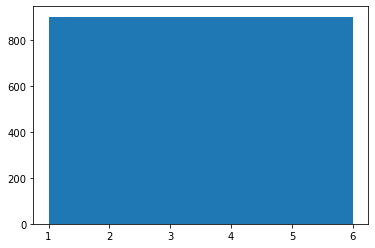

In [30]:
plt.hist(rows, bins = 6)

In [13]:
imread(fns[0])

array([[112, 104, 108, ..., 109, 113, 115],
       [118, 109, 110, ..., 104, 106, 112],
       [121, 112, 109, ..., 106, 101, 102],
       ...,
       [104, 106, 105, ..., 149, 156, 153],
       [109, 103, 101, ..., 152, 144, 144],
       [102, 100, 101, ..., 152, 145, 148]], dtype=uint16)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


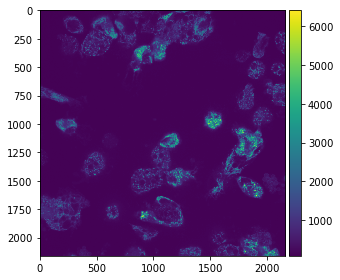

In [15]:
imshow(fns[0])

In [7]:
import sys

In [8]:
sys.path.append('../')
import data_utils

In [9]:
data_utils.size(fns[0])

'243.0 B'

In [21]:
os.stat(os.path.join(image_dir, fns[0]))

os.stat_result(st_mode=33216, st_ino=10, st_dev=54, st_nlink=1, st_uid=30046150, st_gid=30000513, st_size=6579061, st_atime=1661331511, st_mtime=1637774275, st_ctime=1637774275)

In [22]:
from skimage.io import imread, imshow

In [23]:
imread(fns[0])

PermissionError: [Errno 13] Permission denied: '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'